# Liability-friendly equity portfolios

* Intutive approach based on cash-flow matching focus
    * If you can find stocks that pay high dividens you can use thses stock to pay the liabilities when they come. 
    
* Statistical approach based on factor matching focus
    * Look at low-volatility stocks in order to mirror the behaviour of bonds, these will be more attractive for liability hedging
    
* Selecting stocks with above average liability friendliness allows investors to allocate more to equity for a given risk budget
    * This translates to improved performance unless liability friendly stocks strongly underperform the market average (not the case for S&P500 1975-2012)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from my_modules import risk
from my_modules import portfolio
from my_modules import model

import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
n_scenarios = 5000
rates, zc_price = model.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_eq = model.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_price.pct_change().dropna()
rets_7030b = portfolio.bt_mix(rets_eq, rets_zc, allocator=portfolio.fixedmix_allocator, w1=0.7)
pd.concat([portfolio.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           portfolio.terminal_stats(rets_eq, name="Eq", floor=0.75),
           portfolio.terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.98,1.76
std,0.00,0.99,0.60
p_breach,NaN,0.03,0.01
e_short,NaN,0.11,0.07
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


The breaches happen because the allocator is blind to the floor value set.

In [4]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC Prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [6]:
rets_floor75 = portfolio.bt_mix(rets_eq, rets_zc, allocator=portfolio.floor_allocator, floor=.75,  zc_prices=zc_price[1:])
pd.concat([portfolio.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           portfolio.terminal_stats(rets_eq, name="Eq", floor=0.75),
           portfolio.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           portfolio.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.98,1.76,1.96
std,0.00,0.99,0.60,0.99
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.11,0.07,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [7]:
# With the floor75 we are giving up 2 cents in comparison to equities, however we do not face a breach (11 cents)

In [9]:
rets_floor75m1 = portfolio.bt_mix(rets_eq, rets_zc, allocator=portfolio.floor_allocator, floor=.75,  zc_prices=zc_price[1:], m=1)
rets_floor75m5 = portfolio.bt_mix(rets_eq, rets_zc, allocator=portfolio.floor_allocator, floor=.75,  zc_prices=zc_price[1:], m=5)
pd.concat([portfolio.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           portfolio.terminal_stats(rets_eq, name="Eq", floor=0.75),
           portfolio.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           portfolio.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           portfolio.terminal_stats(rets_floor75m1, name="Floor75 m1", floor=0.75),
           portfolio.terminal_stats(rets_floor75m5, name="Floor75 m5", floor=0.75)         
          ],
          axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75 m1,Floor75 m5
mean,1.3433,1.9817,1.7645,1.9560,1.6272,1.9673
std,0.0000,0.9860,0.5971,0.9922,0.4351,0.9952
p_breach,NaN,0.0348,0.0062,NaN,NaN,0.0002
e_short,NaN,0.1092,0.0696,NaN,NaN,0.0002
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# m5 is close to equties in terms of performance but a very small probability of a shortfall with a small size

Instead of using a fixed floor we can use a drawdown allocator. In order to achieve this we need to use cash because of the short duration and the property that it won't fluctuate like the value of a bond.

In [11]:
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    ### For MaxDD
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        ### For MaxDD
        floor_value = (1-maxdd)*peak_value ### Floor is based on Prev Peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        ### For MaxDD
        peak_value = np.maximum(peak_value, account_value) ### For MaxDD
        w_history.iloc[step] = psp_w
    return w_history

In [12]:
cashrate = 0.02
monthly_cashreturn = (1 + cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = portfolio.bt_mix(rets_eq, rets_cash, allocator=portfolio.drawdown_allocator, maxdd=0.25)
tv_rets_maxdd25 = portfolio.terminal_values(rets_maxdd25)

In [13]:
pd.concat([portfolio.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           portfolio.terminal_stats(rets_eq, name="Eq", floor=0.75),
           portfolio.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           portfolio.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           portfolio.terminal_stats(rets_floor75m1, name="Floor75 m1", floor=0.75),
           portfolio.terminal_stats(rets_floor75m5, name="Floor75 m5", floor=0.75),
           portfolio.terminal_stats(rets_maxdd25, name="Max Drawdown 25", floor=0.75),
          ],
          axis=1).round(4)

,ZC,Eq,70/30,Floor75,Floor75 m1,Floor75 m5,Max Drawdown 25
mean,1.3433,1.9817,1.7645,1.9560,1.6272,1.9673,1.6355
std,0.0000,0.9860,0.5971,0.9922,0.4351,0.9952,0.5435
p_breach,NaN,0.0348,0.0062,NaN,NaN,0.0002,NaN
e_short,NaN,0.1092,0.0696,NaN,NaN,0.0002,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
portfolio.summary_stats(rets_maxdd25)["Max Drawdown"].head()

0   -0.178814
1   -0.149800
2   -0.120466
3   -0.155204
4   -0.127105
Name: Max Drawdown, dtype: float64

In [15]:
portfolio.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23499429032176147

In [17]:
tv_eq = portfolio.terminal_values(rets_eq)
tv_zc = portfolio.terminal_values(rets_zc)
tv_7030b = portfolio.terminal_values(rets_7030b)
tv_floor75 = portfolio.terminal_values(rets_floor75)
tv_floor75m1 = portfolio.terminal_values(rets_floor75m1)

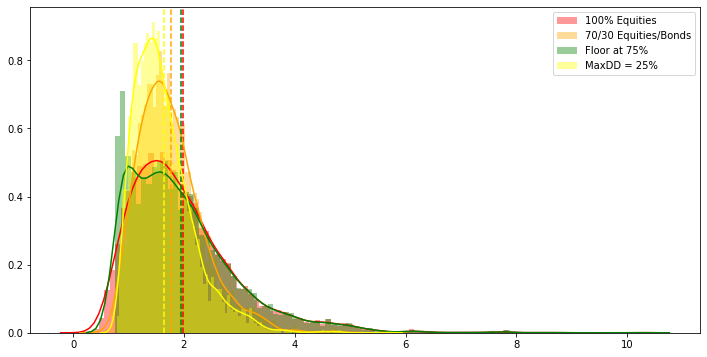

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_rets_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_rets_maxdd25.mean(), ls="--", color="yellow")
plt.legend();